RNN Model


In [16]:
from google.colab import files
uploaded = files.upload()



Saving RELIANCE.csv to RELIANCE (3).csv


Loading dataset

In [18]:
import pandas as pd
import io

df = pd.read_csv(io.BytesIO(uploaded['RELIANCE (3).csv']))
df.head()

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
0,2000-01-03,RELIANCE,EQ,233.05,237.50,251.70,237.50,251.70,251.70,249.37,4456424,1.111319e+14,NaN,NaN,NaN
1,2000-01-04,RELIANCE,EQ,251.70,258.40,271.85,251.30,271.85,271.85,263.52,9487878,2.500222e+14,NaN,NaN,NaN
2,2000-01-05,RELIANCE,EQ,271.85,256.65,287.90,256.65,286.75,282.50,274.79,26833684,7.373697e+14,NaN,NaN,NaN
3,2000-01-06,RELIANCE,EQ,282.50,289.00,300.70,289.00,293.50,294.35,295.45,15682286,4.633254e+14,NaN,NaN,NaN
4,2000-01-07,RELIANCE,EQ,294.35,295.00,317.90,293.00,314.50,314.55,308.91,19870977,6.138388e+14,NaN,NaN,NaN


In [19]:
import pandas as pd
import numpy as np

# Load and prepare the data
df = pd.read_csv('RELIANCE.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')
df = df[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']].dropna().copy()

# Calculate log return and realized volatility
df['LogReturn'] = np.log(df['Close'] / df['Close'].shift(1))
df['Volatility'] = df['LogReturn'].rolling(window=5).apply(lambda x: np.sqrt(np.mean(x**2)))

# Create targets
df['NextClose'] = df['Close'].shift(-1)
df['Direction'] = (df['NextClose'] > df['Close']).astype(int)

df = df.dropna().reset_index(drop=True)


In [20]:
from sklearn.preprocessing import StandardScaler

lookback = 30
features = ['Open', 'High', 'Low', 'Close', 'Volume']
targets = ['NextClose', 'Direction', 'Volatility']

# Normalize features using training split stats
train_mask = df['Date'] < '2017-01-01'
scaler = StandardScaler()
df[features] = scaler.fit_transform(df[features].values)

def create_sequences(df, lookback):
    X, y_price, y_dir, y_vol = [], [], [], []
    for i in range(lookback, len(df)):
        X.append(df[features].iloc[i-lookback:i].values)
        y_price.append(df['NextClose'].iloc[i])
        y_dir.append(df['Direction'].iloc[i])
        y_vol.append(df['Volatility'].iloc[i])
    return np.array(X), np.array(y_price), np.array(y_dir), np.array(y_vol)

X, y_price, y_dir, y_vol = create_sequences(df, lookback)


In [21]:
dates = df['Date'][lookback:].reset_index(drop=True)
X = X[:len(dates)]  # align shapes

train_idx = dates < '2017-01-01'
val_idx = (dates >= '2017-01-01') & (dates <= '2018-12-31')
test_idx = dates > '2018-12-31'

X_train, X_val, X_test = X[train_idx], X[val_idx], X[test_idx]
y_train_price, y_val_price, y_test_price = y_price[train_idx], y_price[val_idx], y_price[test_idx]
y_train_dir, y_val_dir, y_test_dir = y_dir[train_idx], y_dir[val_idx], y_dir[test_idx]
y_train_vol, y_val_vol, y_test_vol = y_vol[train_idx], y_vol[val_idx], y_vol[test_idx]


In [22]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, SimpleRNN, Dense

inp = Input(shape=(lookback, len(features)))
x = SimpleRNN(64)(inp)

# Outputs
out_price = Dense(1, name='price')(x)
out_dir = Dense(1, activation='sigmoid', name='direction')(x)
out_vol = Dense(1, name='volatility')(x)

model = Model(inp, [out_price, out_dir, out_vol])
model.compile(
    optimizer='adam',
    loss={'price': 'mse', 'direction': 'binary_crossentropy', 'volatility': 'mse'},
    metrics={'price': 'mae', 'direction': 'accuracy', 'volatility': 'mse'}
)
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 30, 5)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ simple_rnn          │ (None, 64)        │      4,480 │ input_layer_1[0]… │
│ (SimpleRNN)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ price (Dense)       │ (None, 1)         │         65 │ simple_rnn[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ direction (Dense)   │ (None, 1)         │         65 │ simple_rnn[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ volatility (Dense)  │ (None, 1)         │         65 │ simple_rnn[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,675 (18.26 KB)

 Trainable params: 4,675 (18.26 KB)

 Non-trainable params: 0 (0.00 B)

Fitting Model

In [23]:
history = model.fit(
    X_train,
    {'price': y_train_price, 'direction': y_train_dir, 'volatility': y_train_vol},
    validation_data=(X_val, {
        'price': y_val_price,
        'direction': y_val_dir,
        'volatility': y_val_vol
    }),
    epochs=30,
    batch_size=32
)


Epoch 1/30
132/132 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - direction_accuracy: 0.4949 - direction_loss: 0.7109 - loss: 1129747.0000 - price_loss: 1129679.2500 - price_mae: 907.7438 - volatility_loss: 0.3876 - volatility_mse: 0.3876 - val_direction_accuracy: 0.5344 - val_direction_loss: 0.6920 - val_loss: 1260406.0000 - val_price_loss: 1258620.0000 - val_price_mae: 1101.8309 - val_volatility_loss: 0.0034 - val_volatility_mse: 0.0035
Epoch 2/30
132/132 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - direction_accuracy: 0.4944 - direction_loss: 0.6981 - loss: 1155907.6250 - price_loss: 1155909.3750 - price_mae: 917.4299 - volatility_loss: 0.0050 - volatility_mse: 0.0050 - val_direction_accuracy: 0.5364 - val_direction_loss: 0.6922 - val_loss: 1242306.7500 - val_price_loss: 1240517.8750 - val_price_mae: 1093.5966 - val_volatility_loss: 9.3851e-04 - val_volatility_mse: 9.7188e-04
Epoch 3/30
132/132 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - direction_accuracy: 0.5024 - direction_loss: 0.6943 - loss: 1173103.3750 

In [24]:
results = model.evaluate(X_test, {
    'price': y_test_price,
    'direction': y_test_dir,
    'volatility': y_test_vol
})

print("\nTest Results:", results)

preds = model.predict(X_test)
pred_price, pred_dir, pred_vol = preds


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - direction_accuracy: 0.4842 - direction_loss: 0.6945 - loss: 1394915.2500 - price_loss: 1394914.6250 - price_mae: 1152.4819 - volatility_loss: 1.3748e-04 - volatility_mse: 1.3748e-04

Test Results: [2002300.25, 2002299.5, 0.6934860348701477, 0.00017825240502133965, 0.5017361044883728, 1368.2178955078125, 0.00017825240502133965]
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


Visualisation

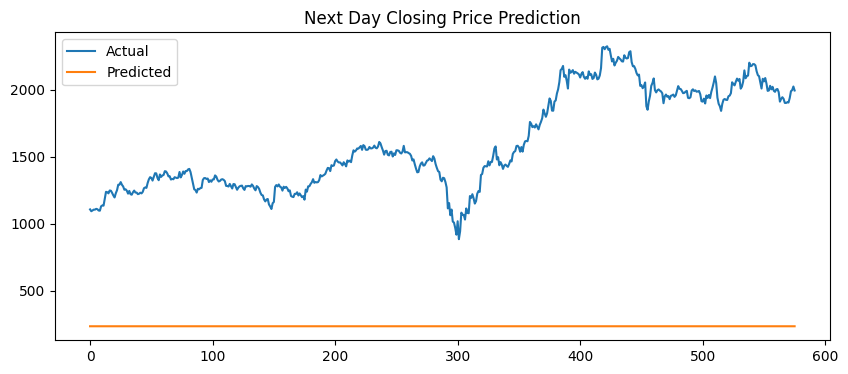

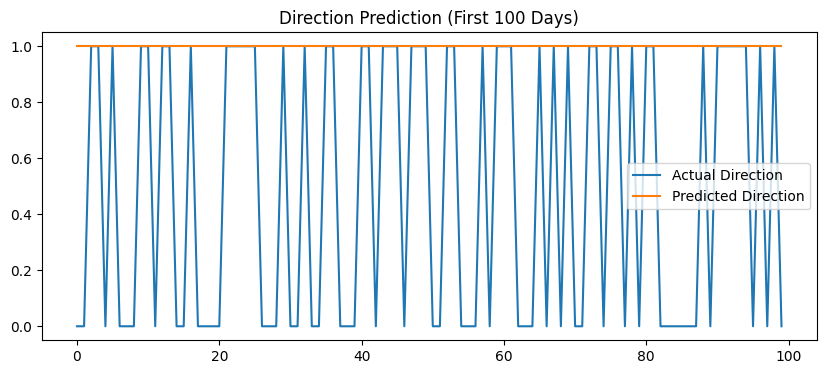

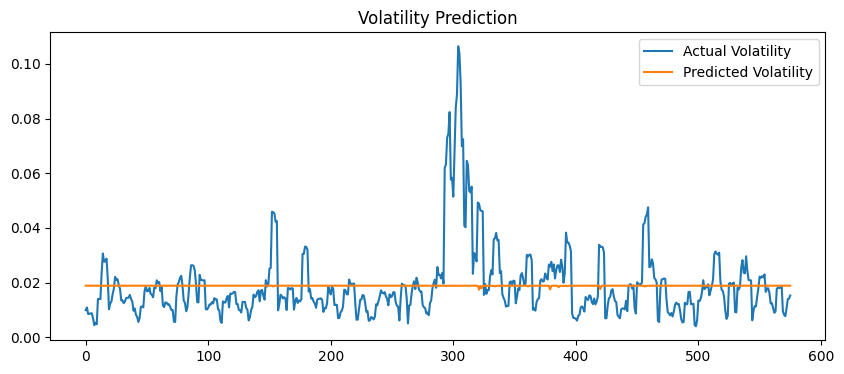

In [25]:
import matplotlib.pyplot as plt

# Plot predicted vs actual closing price
plt.figure(figsize=(10, 4))
plt.plot(y_test_price, label="Actual")
plt.plot(pred_price, label="Predicted")
plt.title("Next Day Closing Price Prediction")
plt.legend()
plt.show()

# Plot predicted direction
plt.figure(figsize=(10, 4))
plt.plot(y_test_dir[:100], label="Actual Direction")
plt.plot((pred_dir > 0.5)[:100], label="Predicted Direction")
plt.title("Direction Prediction (First 100 Days)")
plt.legend()
plt.show()

# Plot predicted volatility
plt.figure(figsize=(10, 4))
plt.plot(y_test_vol, label="Actual Volatility")
plt.plot(pred_vol, label="Predicted Volatility")
plt.title("Volatility Prediction")
plt.legend()
plt.show()


In [26]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score

# -----------------------------
# Add predictions to a DataFrame
# -----------------------------
results_df = pd.DataFrame({
    'Date': dates[test_idx].values,
    'Actual_Close': y_test_price,
    'Predicted_Close': pred_price.flatten(),
    'Actual_Direction': y_test_dir,
    'Predicted_Direction': (pred_dir.flatten() > 0.5).astype(int),
    'Actual_Volatility': y_test_vol,
    'Predicted_Volatility': pred_vol.flatten()
})

# -----------------------------
# Calculate Evaluation Metrics
# -----------------------------

# Closing Price
mse_price = mean_squared_error(y_test_price, pred_price)
rmse_price = np.sqrt(mse_price)
mae_price = mean_absolute_error(y_test_price, pred_price)

# Direction (Classification)
accuracy_dir = accuracy_score(y_test_dir, (pred_dir.flatten() > 0.5).astype(int))

# Volatility
mse_vol = mean_squared_error(y_test_vol, pred_vol)
rmse_vol = np.sqrt(mse_vol)
mae_vol = mean_absolute_error(y_test_vol, pred_vol)

# -----------------------------
# Print Report
# -----------------------------
print("\n📊 Model Evaluation Report")
print(f"🔹 Closing Price → MSE: {mse_price:.4f}, RMSE: {rmse_price:.4f}, MAE: {mae_price:.4f}")
print(f"🔹 Direction     → Accuracy: {accuracy_dir*100:.2f}%")
print(f"🔹 Volatility    → MSE: {mse_vol:.6f}, RMSE: {rmse_vol:.6f}, MAE: {mae_vol:.6f}")

# -----------------------------
# Save and optionally download CSV
# -----------------------------
results_df.to_csv("rnn_predictions_report.csv", index=False)

# For Colab users – download it
try:
    from google.colab import files
    files.download("rnn_predictions_report.csv")
except ImportError:
    print("✅ Saved 'rnn_predictions_report.csv' to current folder.")



📊 Model Evaluation Report
🔹 Closing Price → MSE: 2002299.3707, RMSE: 1415.0263, MAE: 1368.2179
🔹 Direction     → Accuracy: 50.17%
🔹 Volatility    → MSE: 0.000178, RMSE: 0.013351, MAE: 0.008244


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [27]:
results_df.head()  # shows the first 5 rows


,Date,Actual_Close,Predicted_Close,Actual_Direction,Predicted_Direction,Actual_Volatility,Predicted_Volatility
0,2019-01-01,1106.40,233.738663,0,1,0.009962,0.018882
1,2019-01-02,1092.75,233.738724,0,1,0.010930,0.018884
2,2019-01-03,1098.65,233.738663,1,1,0.008525,0.018883
3,2019-01-04,1104.75,233.738632,1,1,0.008598,0.018882
4,2019-01-07,1104.65,233.738586,0,1,0.008783,0.018882
